Using device: cuda
LR=1e-04, BS=128 => Acc=90.17%
LR=1e-04, BS=256 => Acc=88.75%
LR=1e-04, BS=512 => Acc=87.00%
LR=3e-04, BS=128 => Acc=92.41%
LR=3e-04, BS=256 => Acc=91.68%
LR=3e-04, BS=512 => Acc=90.48%
LR=1e-03, BS=128 => Acc=93.43%
LR=1e-03, BS=256 => Acc=93.07%
LR=1e-03, BS=512 => Acc=92.91%


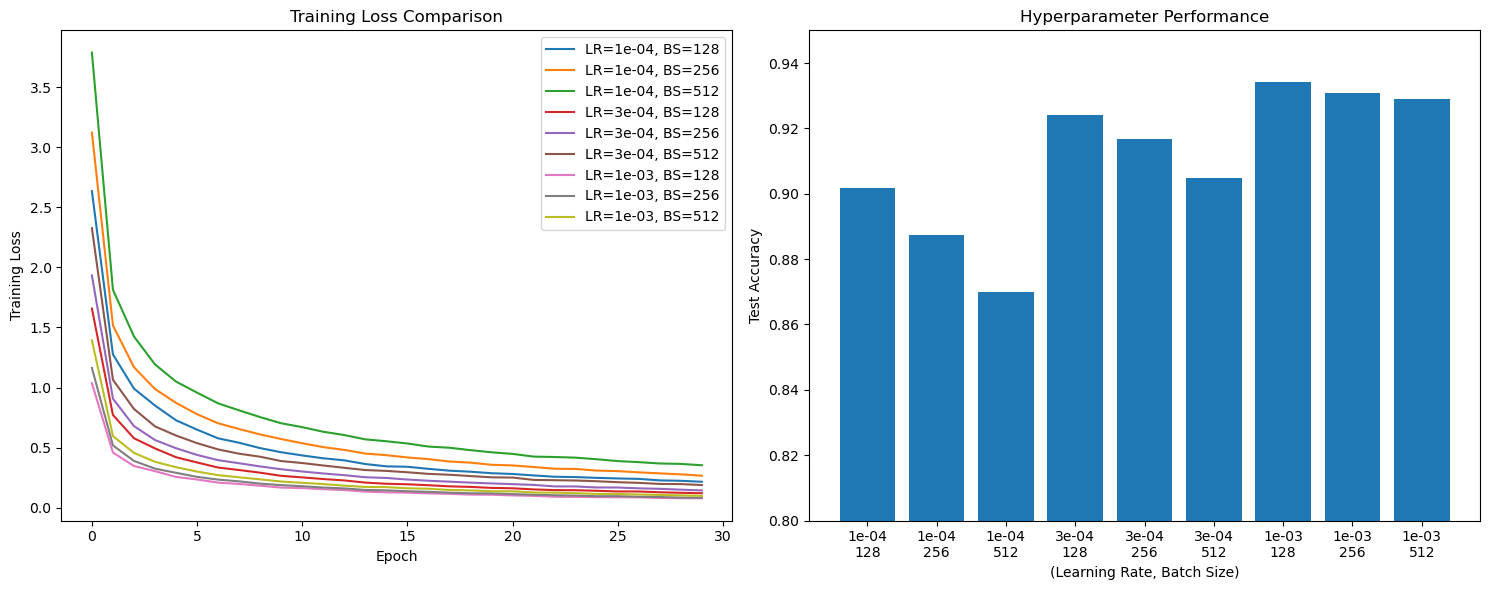

In [11]:
# 导入必要的包
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation
from torchvision.datasets import KMNIST
from torch.utils.data import DataLoader
# 检测CUDA可用性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

learning_rates = [1e-4, 3e-4, 1e-3]  # 学习率候选值
batch_sizes = [128, 256, 512]       # 批次大小候选值
epochs = 30                         # 保持原训练轮次
# 数据增强与归一化
transform = Compose([
    RandomRotation(10),       # 随机旋转增强
    ToTensor(),
    Normalize((0.5,), (0.5,)) # 归一化到[-1, 1]
])

# 数据集加载
train_data = KMNIST(root='./KMNIST_data', train=True, download=True,
                    transform=transform)
test_data = KMNIST(root='./KMNIST_data', train=False, download=True,
                   transform=Compose([ToTensor(), Normalize((0.5,), (0.5,))]))



# 定义增强模型
class ImprovedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 10)
        )
        # 权重初始化
        self._init_weights()
    
    def _init_weights(self):
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(layer.bias, 0)
    
    def forward(self, x):
        return self.net(x)

# 初始化模型、损失函数、优化器
def train_model(lr, batch_size):
    # 数据加载器
    train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)
    test_dl = DataLoader(test_data, batch_size=batch_size*2,pin_memory=True)
    
    # 模型初始化（确保每次重新初始化）
    model = ImprovedModel().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # 训练监控数据
    train_losses = []
    
    # 训练循环
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for data, target in train_dl:
            optimizer.zero_grad()
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * data.size(0)
        
        epoch_loss = running_loss / len(train_data)
        train_losses.append(epoch_loss)
    
    # 测试评估
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_dl:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    return train_losses, correct / total
# 存储实验结果
results = []

# 参数搜索主循环
for lr in learning_rates:
    for bs in batch_sizes:
        # 固定随机种子保证公平比较
        torch.manual_seed(42)
        
        # 执行训练
        losses, acc = train_model(lr, bs)
        
        # 记录结果
        results.append({
            'lr': lr,
            'batch_size': bs,
            'train_loss': losses,
            'test_acc': acc
        })
        print(f'LR={lr:.0e}, BS={bs} => Acc={acc*100:.2f}%')
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# 训练曲线对比
plt.subplot(1, 2, 1)
for res in results:
    label = f"LR={res['lr']:.0e}, BS={res['batch_size']}"
    plt.plot(res['train_loss'], label=label)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()

# 测试准确率对比
plt.subplot(1, 2, 2)
x_labels = [f"{res['lr']:.0e}\n{res['batch_size']}" for res in results]
acc_values = [res['test_acc'] for res in results]
plt.bar(x_labels, acc_values)
plt.ylim(0.8, 0.95)
plt.xlabel('(Learning Rate, Batch Size)')
plt.ylabel('Test Accuracy')
plt.title('Hyperparameter Performance')

plt.tight_layout()
plt.show()